In [1]:
%load_ext autoreload
%autoreload 2

import typing as ty
from functools import partial

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, HTML

import iccas as ic
import util

# Matplotlib settings and utilities
%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams.update({
    'axes.titlesize': 16,
    'axes.titley': 1.03,
    'axes.labelsize': 14
})

ic.set_locale('it')

## Correzione e pre-elaborazione dei dati

I dati originali estratti dai bollettini PDF dell'ISS sono a tratti inconsistenti. Il numero di casi/decessi totali dall'inizio della pandemia dovrebbe infatti crescere nel tempo ma in alcuni tratti le serie temporali decrescono per poi tornare nuovamente a crescere. Questo problema è in realtà presente in maniera rilevante solo nei dati sui decessi ed è quasi del tutto assente nei dati sui casi. 

Visto che il più delle volte non si tratta di singoli punti anomali, presumo che le decrescite a valori più bassi siano dovute a rettifiche dei dati. Dunque, nel correggere i dati, ho assunto che i valori della serie che raggiungono temporaneamente livelli più alti di valori successivi siano invalidi e li ho sostituiti con valori interpolati (metodo PCHIP).

Per maggiori dettagli si veda `Correzione_dati.ipynb`.

<center><img src='esempio_correzione.png'></center>

In [2]:
# Load original data, take only cases and deaths counts and fix monotonicity as explained above
data = ic.fix_monotonicity(ic.only_counts(ic.get()))
(data.cases.tail(5).style
     .set_caption("Casi dall'inizio della pandemia (ultimi 5 bollettini)")
)

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,>=90,unknown
date,,,,,,,,,,,
2020-10-27 11:00:00,17115,39862,62925,61176,77187,91208,59521,51553,54214,23462,101
2020-11-07 11:00:00,29237,73182,104884,101273,128375,146908,90879,71995,69340,28400,106
2020-11-11 11:00:00,34309,85064,122052,118862,151099,172707,105716,82135,76991,30926,114
2020-11-18 11:00:00,43841,105378,152675,150360,193504,220532,134416,102186,92089,36266,120
2020-11-25 11:00:00,51938,122212,178532,178453,230654,262420,160621,121048,107062,41474,115


I dati dei bollettini non sono uniformemente distribuiti nel tempo. Essi erano inizialmente bisettimanali e sono adesso settimanali, ma la cadenza non è mai stata regolare. Per alcuni grafici, mi è utile avere dati giornalieri. Otterò tali dati per interpolazione.

In [3]:
# Day-by-day interpolated data. 
# Note: ic.resample behaves better than DataFrame.resample() + interpolate() for my use case. See the docstring for more info.
resampled = ic.resample(data, freq='1D', hour=18, method='pchip')
(resampled.cases.tail().style
     .set_caption("Casi totali dall'inizio della pandemia (dati interpolati, ultimi 5 giorni)")
)

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,>=90,unknown
date,,,,,,,,,,,
2020-11-21 18:00:00,47820,113706,165401,163982,211605,240943,147042,111201,99145,38731,119
2020-11-22 18:00:00,48970,116097,169075,167979,216888,246899,150773,113890,101284,39475,118
2020-11-23 18:00:00,50092,118417,172652,171907,222065,252736,154453,116554,103419,40215,117
2020-11-24 18:00:00,51183,120665,176130,175764,227132,258450,158082,119193,105553,40953,116
2020-11-25 18:00:00,52244,122838,179506,179549,232088,264036,161659,121808,107683,41688,115


## Numero medio di casi/decessi per periodi di N giorni

In [4]:
util.with_interaction(
    util.display_averages_by_period_table,
    controls=dict(
        data = widgets.fixed(data),
        variable = util.variable_form_field(),
        freq = ('Periodi', widgets.SelectionSlider(
            options=[('14 giorni', 14), ('28 giorni', 28), ('Mesi', 'M')],
            value='M'
        )),
        age_group_size = util.age_group_size_form_field(10),
        normalize = ('Percentuali', widgets.Checkbox(value=True)),
        gradient_axis = ('Asse gradiente', widgets.Dropdown(
            options=[("Verticale", 0), ("Orizzontale", 1)],
            value=1,
        ),)
    ),
    output_position='right'
)

In [5]:
util.with_interaction(
    ic.charts.bar.average_by_period_bar_chart,
    controls=dict(
        counts = widgets.fixed(data),
        variable = util.variable_form_field(),
        age_group_size = util.age_group_size_form_field(),
        freq = ('Periodi', widgets.SelectionSlider(
            options=[('7 giorni', 7), ('14 giorni', 14), ('28 giorni', 28), ('Mesi', 'M')],
            value=28
        )),
        normalize = ('Normalizza', widgets.Checkbox(value=True)),
        stacked = ('Barre impilate', widgets.Checkbox(value=True)),
        ylim = ('Limite asse y (%)', widgets.FloatSlider(value=1.0, min=0.05, max=1.0, step=0.05, continuous_update=True)),
    ),
    output_position='right',
)

## Media mobile a N giorni dei nuovi casi/decessi

Versione continua del grafico precedente.

In [6]:
import iccas as ic

util.with_interaction(
    ic.charts.double_area_chart_of_running_averages,
    controls=dict(
        data = widgets.fixed(resampled),
        variable = util.variable_form_field(),
        window = util.window_form_field(7),
        age_group_size = util.age_group_size_form_field(),
        period = util.period_form_field(resampled.index)
    )
)

In [7]:
def lineplot_age_group(resampled, variable='cases', age_range=(60, None), window=14, period=None):
    fig, ax = plt.subplots(figsize=(13, 8))
    age_islice = slice(
        age_range[0] // 10,
        age_range[1] // 10 if age_range[1] is not None else None,
    )
    d = resampled[variable].iloc[:, age_islice].sum(axis=1).diff(window).dropna() / window
    d.plot(ax=ax)
    ax.set_xlabel('')
    if age_range[1] is None or age_range[1] > 90:
        title = f'Nuovi casi giornalieri di età superiore ai {age_range[0]} anni'
    else:
        a, b = age_range
        title = f'Nuovi casi giornalieri di età compresa tra i {a} e i {b} anni'
    if window > 1:
        title = f'Media mobile a {window} giorni dei {title.lower()}'
    ax.set_title(title)


age_labels = list(range(0, 91, 10)) + ['[nessun limite]']
age_values = list(range(0, 91, 10)) + [None]
util.with_interaction(
    lineplot_age_group,
    controls=dict(
        resampled=widgets.fixed(resampled),
        variable=util.variable_form_field(),
        window=util.window_form_field(),
        age_range=("Range d'età", widgets.SelectionRangeSlider(options=list(zip(age_labels, age_values)), index=(6, 10)))
    )
)

# Animazione: distribuzione d'età dei nuovi casi nel tempo

In [ ]:
population_by_age = ic.get_population_by_age_group().value
population_age_distribution = population_by_age / population_by_age.sum()

_, ax = plt.subplots(figsize=(13, 8))
anim = ic.charts.AgeDistributionBarChart(
    ax=ax,
    counts=resampled, 
    variable='cases',
    normalize=True,
    age_group_size=10,
    window=7,
    population_distribution=population_age_distribution,
).animation(interval=80)

plt.close()  # Do not remove

# This takes time (~40 secs)
HTML(anim.to_jshtml())

## Tasso di letalità

Nei PDF dell'ISS, il tasso di letalità per ogni fascia d'età è calcolato dividendo il numero totale di casi per il numero totale di morti alla stessa data. Questo distorce la stima, dal momento che tra la data della diagnosi a quella del decesso passano normalmente alcuni giorni.

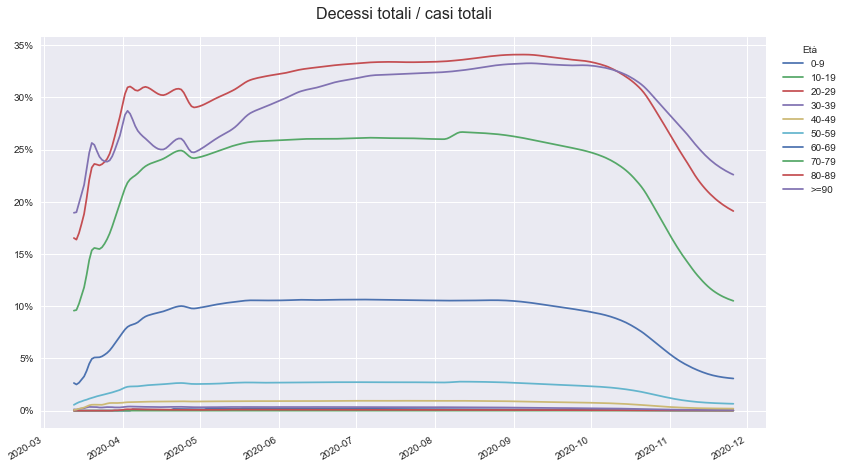

In [9]:
def lineplot_fatality_rate(ax, cfr, title=''):
    cfr.plot(ax=ax, title=title, xlabel='')
    ic.charts.common.legend(ax=ax, title='Età');
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0, decimals=0))

naive_cfr = ic.fatality_rate(resampled, shift=0)
_, ax = plt.subplots(figsize=(13, 8))
lineplot_fatality_rate(ax, naive_cfr,  title='Decessi totali / casi totali')

E' difficile produrre una stima precisa della letalità sulla base dei soli dati che abbiamo a disposizione (i casi e i decessi totali). Potremmo ottenere una stima migliore dividendo il numero di morti alla data $T$ per il numero di casi $N$ giorni prima, dove $N$ è il numero mediano di giorni che intercorrono tra la data di diagnosi e quella del decesso. Purtroppo, nemmeno questo dato è disponibile. Tuttavia, in [questo report dell'ISS](https://www.epicentro.iss.it/coronavirus/sars-cov-2-decessi-italia#8) sono disponibili i tempi mediani che intercorrono tra l'insorgenza dei sintomi, il ricovero e il decesso.

In [10]:
# Source: https://www.epicentro.iss.it/coronavirus/sars-cov-2-decessi-italia#8
MEDIAN_DAYS_FROM_SYMPTOMS_TO_DEATH = 12
MEDIAN_DAYS_FROM_HOSPITALIZATION_TO_DEATH = 5

def fatality_rate_table(cfr):
    if isinstance(cfr, pd.Series):
        cfr = cfr.to_frame(name='Case Fatality Rate')
    return (
        cfr.style
        .format('{:.2%}')
        .bar(vmax=1.0)
    )

def fatality_rate_comparison_table(resampled, shift):
    cfr_no_shift = resampled.deaths.iloc[-1] / resampled.cases.iloc[-1]
    cfr_with_shift = resampled.deaths.iloc[-1] / resampled.cases.iloc[-1-shift]
    cfr_no_shift_label = 'Decessi totali / Casi totali'
    cfr_with_shift_label = f'Decessi totali / Casi totali {shift} giorni prima'
    comparison = pd.DataFrame({
        cfr_no_shift_label: cfr_no_shift,
        cfr_with_shift_label: cfr_with_shift
    })
    display(fatality_rate_table(comparison))

util.with_interaction(
    fatality_rate_comparison_table,
    controls=dict(
        resampled=widgets.fixed(resampled),
        shift=('Shift', widgets.IntSlider(7, min=1, max=14))
    ),
)